# Hyperparameter Tuning using HyperDrive

In [1]:
import logging
import os
import csv
import json
import joblib
import numpy as np
import pandas as pd
from sklearn import datasets
import pkg_resources
from shutil import copy

#AZURE ML CORE AND PIPELINE
import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.model import InferenceConfig
from azureml.core.workspace import Workspace
from azureml.core.dataset import Dataset
from azureml.core.runconfig import RunConfiguration
from azureml.core import ScriptRunConfig, Datastore, Environment, Model
from azureml.core.conda_dependencies import CondaDependencies
from azureml.pipeline.core import Pipeline, PipelineData, PipelineRun, TrainingOutput
from azureml.train.estimator import Estimator
from azureml.widgets import RunDetails

#HYPERDRIVE
from azureml.train.hyperdrive import PrimaryMetricGoal
from azureml.train.hyperdrive.sampling import BayesianParameterSampling
from azureml.train.hyperdrive.runconfig import HyperDriveConfig
from azureml.train.hyperdrive.parameter_expressions import quniform, choice
from azureml.pipeline.steps import HyperDriveStep, HyperDriveStepRun, PythonScriptStep

from azureml.core.webservice import AciWebservice

#METRICS
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, plot_confusion_matrix, classification_report, precision_recall_curve
import matplotlib.pyplot as plt

import xgboost as xgb
xgb.__version__
# Check core SDK version number
print("SDK version:", azureml.core.VERSION)

SDK version: 1.20.0


## Get Workspace, Datastore and create Experiment

In [2]:
azureml._restclient.snapshots_client.SNAPSHOT_MAX_SIZE_MEGABYTES = 2000
ws = Workspace.from_config()
experiment_name = 'Custom_Health_Insurance_CS'

exp = Experiment(ws, experiment_name)
def_blob_store = Datastore(ws, "workspaceblobstore")

## Attach GPU computetarget

In [3]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
from azureml.core.compute_target import ComputeTargetException

amlcompute_cluster_name = "MS-GPUcompute"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NC6',
                                                           vm_priority = 'lowpriority',
                                                           max_nodes=8)
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True, min_node_count = 1, timeout_in_minutes = 2)

Found existing cluster, use it.
Succeeded........................
AmlCompute wait for completion finished

Wait timeout has been reached
Current provisioning state of AmlCompute is "Succeeded" and current node count is "0"


## Dataset

In [4]:
# Try to load the dataset from the Workspace. Otherwise, create it from the file
found = False
key = "Health insurance cross sell"

if key in ws.datasets.keys(): 
        found = True
        dataset = ws.datasets[key] 

if not found:
        # Create AML Dataset and register it into Workspace
        dl_data = 'https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction/download'
        dataset = Dataset.Tabular.from_delimited_files(dl_data)        
        #Register Dataset in Workspace
        dataset = dataset.register(workspace=ws,
                                   name=key,
                                   description="https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction")


## Create runconfig for prep.py

In [5]:
#Create runconfiguration for preprocessing step
aml_run_config = RunConfiguration()
aml_run_config.target = compute_target

aml_run_config.environment.python.user_managed_dependencies = False

aml_run_config.environment.python.conda_dependencies = CondaDependencies.create(
    conda_packages=['pandas','scikit-learn','numpy', 'matplotlib', 'seaborn', 'imbalanced-learn'],
    pip_packages=['joblib','azureml-sdk','phik'],
    pin_sdk_version=False
)

## Create custom enviroment for train and score script

In [6]:
# Create custom enviroment with XGBoost dependecies and RapidsAI/GPU support for train and score script
myenv = Environment("xgboost")
myenv.docker.enabled = True
myenv.docker.base_image = "rapidsai/rapidsai-nightly"
conda_dep = CondaDependencies()
conda_dep.add_conda_package("python=3.6")
conda_dep.add_conda_package("pip==19.2.3")
conda_dep.add_conda_package("nb_conda_kernels==2.2.2")
conda_dep.add_conda_package("pandas")
conda_dep.add_conda_package("scikit-learn")
conda_dep.add_conda_package("numpy")
conda_dep.add_conda_package("onnx")
#conda_dep.add_conda_package("xgboost")
conda_dep.add_conda_package("joblib")
conda_dep.add_pip_package("azureml-defaults") #, "prompt_toolkit==2.0.9", "azure-cli==2.0.77", "azureml-core>= 1.18.0"
conda_dep.add_pip_package("xgboost==0.90")
conda_dep.add_pip_package("onnxmltools")
conda_dep.add_pip_package("skl2onnx")
myenv.python.conda_dependencies=conda_dep
myenv.inferencing_stack_version='latest'

## Create placeholders for dataset, scaler and model

In [7]:
raw_data = dataset.as_named_input('raw_data')
X_train = PipelineData("X_train", datastore=def_blob_store).as_dataset()
X_test = PipelineData("X_test", datastore=def_blob_store).as_dataset()
y_train = PipelineData("y_train", datastore=def_blob_store).as_dataset()
y_test = PipelineData("y_test", datastore=def_blob_store).as_dataset()
scaler_file = PipelineData("scaler_file", datastore=def_blob_store, output_path_on_compute="./scaler2/")

saved_model = PipelineData(name='saved_model',
                           datastore=def_blob_store,
                           pipeline_output_name= "hd_model_output",
                           training_output=TrainingOutput("Model", metric="accuracy", model_file="outputs/model/hd_model_joblib.joblib.dat"))

onnx_model = PipelineData(name='onnx_model', datastore=def_blob_store)

## Hyperdrive Configuration

Based on experience I have choosen below hyperparameters to search over. These are the ones with the most impact on model performance. 

In [8]:
ps = BayesianParameterSampling({
    '--learning_rate': choice(0.1, 0.05),
    '--n_estimators': quniform(1200,2500,200),
    '--max_depth': quniform(12,24,2),
    '--subsample': choice(0.8,0.9),
    '--colsample_bytree': choice(0.8,0.9)
})


# Create a Xgboost estimator for use with train.py
est = Estimator(source_directory='./train/', entry_script='train.py', compute_target=compute_target, environment_definition=myenv)

hyperdrive_run_config = HyperDriveConfig(
                                         hyperparameter_sampling=ps, 
                                         primary_metric_name='Accuracy',
                                         primary_metric_goal=PrimaryMetricGoal.MAXIMIZE,
                                         max_total_runs=40,
                                         max_concurrent_runs=4,
                                        policy=None,
                                        #run_config=run_config
                                        estimator=est
                                        )

'Estimator' is deprecated. Please use 'ScriptRunConfig' from 'azureml.core.script_run_config' with your own defined environment or an Azure ML curated environment.
For best results with Bayesian Sampling we recommend using a maximum number of runs greater than or equal to 20 times the number of hyperparameters being tuned. Recommendend value:100.


## Create steps and pipeline

In [9]:
#Preprocessing step
source_directory="./prep/"
prep_step = PythonScriptStep(name="prep_step",
                        script_name="prep.py",
                        arguments=["--X_train", X_train, "--X_test", X_test, "--y_train", y_train, "--y_test", y_test, "--scaler", scaler_file],
                        inputs=[raw_data],
                        outputs=[X_train, X_test, y_train, y_test, scaler_file],
                        compute_target=compute_target,
                        runconfig=aml_run_config,
                        source_directory=source_directory,
                        allow_reuse=True)

In [10]:
#Hyperdrive step
hd_step = HyperDriveStep(
                        name="hd_step",
                        hyperdrive_config=hyperdrive_run_config,
                        estimator_entry_script_arguments=["--X_train", X_train,
                                                          "--X_test", X_test,
                                                          "--y_train", y_train,
                                                          "--y_test", y_test,
                                                          "--saved_model", saved_model,
                                                          "--onnx_model", onnx_model],
                        inputs=[X_train, X_test, y_train, y_test],
                        outputs=[saved_model, onnx_model])

In [11]:
#Register model step including dependecies
conda_dep = CondaDependencies()
conda_dep.add_pip_package("azureml-sdk")

rcfg = RunConfiguration(conda_dependencies=conda_dep)

register_model_step = PythonScriptStep(script_name='register_model.py',
                                       name="register_model",
                                       source_directory='./register/',
                                       inputs=[saved_model],
                                       compute_target=compute_target,
                                       arguments=["--saved_model", saved_model],
                                       allow_reuse=True,
                                       runconfig=rcfg)

register_model_step.run_after(hd_step)

## Run Details
Submit pipeline and get run details

In [12]:
pipeline1 = Pipeline(default_source_directory=".", default_datastore=def_blob_store, workspace=ws, steps=[prep_step, hd_step, register_model_step]) # 
pipeline1.validate()
pipeline_run = Experiment(ws, 'health_insuarance').submit(pipeline1, regenerate_outputs=False) #, show_output=False
RunDetails(pipeline_run).show()

Created step prep_step [b97eeb21][46a89bd8-b42f-4dc4-8482-0e0ab72fedea], (This step is eligible to reuse a previous run's output)
Created step hd_step [87d9b26b][c4b7c77d-34c5-45b9-8d90-83709d16c28e], (This step is eligible to reuse a previous run's output)
Created step register_model [ed17b613][bc5078b2-5b6f-4438-9c6d-8d633d6d9333], (This step is eligible to reuse a previous run's output)
Submitted PipelineRun 781d91d7-1fc0-47f9-be36-81f275ef3452
Link to Azure Machine Learning Portal: https://ml.azure.com/experiments/health_insuarance/runs/781d91d7-1fc0-47f9-be36-81f275ef3452?wsid=/subscriptions/336509a3-005c-4650-b1e5-e1c99e57a5e1/resourcegroups/ms_test/workspaces/michaels_test1


_PipelineWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', …

In [13]:
pipeline_run.wait_for_completion()

PipelineRunId: 781d91d7-1fc0-47f9-be36-81f275ef3452
Link to Azure Machine Learning Portal: https://ml.azure.com/experiments/health_insuarance/runs/781d91d7-1fc0-47f9-be36-81f275ef3452?wsid=/subscriptions/336509a3-005c-4650-b1e5-e1c99e57a5e1/resourcegroups/ms_test/workspaces/michaels_test1
PipelineRun Status: NotStarted
PipelineRun Status: Running


StepRunId: 5d33db3b-d936-4d85-9f09-002e081378ae
Link to Azure Machine Learning Portal: https://ml.azure.com/experiments/health_insuarance/runs/5d33db3b-d936-4d85-9f09-002e081378ae?wsid=/subscriptions/336509a3-005c-4650-b1e5-e1c99e57a5e1/resourcegroups/ms_test/workspaces/michaels_test1

StepRun(prep_step) Execution Summary
StepRun( prep_step ) Status: Finished
{'runId': '5d33db3b-d936-4d85-9f09-002e081378ae', 'target': 'MS-GPUcompute', 'status': 'Completed', 'startTimeUtc': '2021-02-13T13:10:23.170761Z', 'endTimeUtc': '2021-02-13T13:10:23.220477Z', 'properties': {'azureml.reusedrunid': 'b2a059e5-70af-4dc5-a473-7b2bf0117173', 'azureml.reusedno

'Finished'

## Best Model


In [14]:
model = Model(name="Health_XGBoost_HD", version=None, workspace=ws)
print(model)

Model(workspace=Workspace.create(name='michaels_test1', subscription_id='336509a3-005c-4650-b1e5-e1c99e57a5e1', resource_group='ms_test'), name=Health_XGBoost_HD, id=Health_XGBoost_HD:12, version=12, tags={}, properties={})


In [15]:
model_path = Model.get_model_path(model_name="Health_XGBoost_HD", version=None, _workspace=ws)
xgb_model = joblib.load(model_path)
print("BEST PERFORMING XGBOOST MODEL")
print(xgb_model)

BEST PERFORMING XGBOOST MODEL
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=0,
              learning_rate=0.05, max_delta_step=0, max_depth=24,
              min_child_weight=1, missing=nan, n_estimators=1800, n_jobs=1,
              nthread=None, objective='binary:logistic',
              predictor='gpu_predictor', random_state=42, reg_alpha=0.1,
              reg_lambda=1, sampling_method='gradient_based',
              scale_pos_weight=1, seed=None, silent=None, subsample=0.9,
              tree_method='gpu_hist', verbosity=1)


Trying to unpickle estimator LabelEncoder from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.


## Metrics for best performing model

In [16]:
# Make scaler available for the score script by downloading it from Datastore

prep_step = pipeline_run.find_step_run('prep_step')

prep_scaler_ref = prep_step[0].get_output_data("scaler_file")
prep_xtest_ref = prep_step[0].get_output_data("X_test")
prep_ytest_ref = prep_step[0].get_output_data("y_test")

def_blob_store.download(
    target_path='./output/', # str: local directory to download to
    prefix=prep_scaler_ref.path_on_datastore,
    overwrite=True,
    )

def_blob_store.download(
    target_path='./output/', # str: local directory to download to
    prefix=prep_xtest_ref.path_on_datastore,
    overwrite=True,
    )

def_blob_store.download(
    target_path='./output/', # str: local directory to download to
    prefix=prep_ytest_ref.path_on_datastore,
    overwrite=True,
    )

scaler_path = f"./output/{prep_scaler_ref.path_on_datastore}/scaler.pkl"
X_test_path = f"./output/{prep_xtest_ref.path_on_datastore}/X_test.csv"
y_test_path = f"./output/{prep_ytest_ref.path_on_datastore}/y_test.csv"
copy(scaler_path, "./score/")


Downloaded azureml/b2a059e5-70af-4dc5-a473-7b2bf0117173/scaler_file/scaler.pkl, 1 files out of an estimated total of 1
Downloaded azureml/b2a059e5-70af-4dc5-a473-7b2bf0117173/X_test/X_test.csv, 1 files out of an estimated total of 1
Downloaded azureml/b2a059e5-70af-4dc5-a473-7b2bf0117173/y_test/y_test.csv, 1 files out of an estimated total of 1


'./score/scaler.pkl'

ACCURACY: 0.9057174819173716
ROC AUC SCORE: 0.97
              precision    recall  f1-score   support

         0.0       0.90      0.91      0.91     65153
         1.0       0.91      0.90      0.91     65359

    accuracy                           0.91    130512
   macro avg       0.91      0.91      0.91    130512
weighted avg       0.91      0.91      0.91    130512

CONFUSION MATRIX: [[59177  5976]
 [ 6329 59030]]


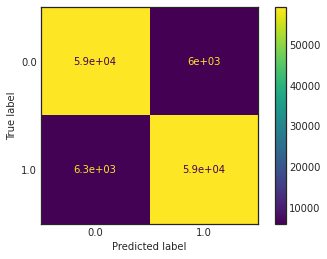

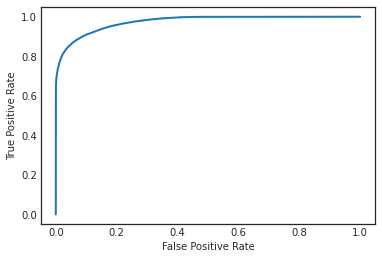

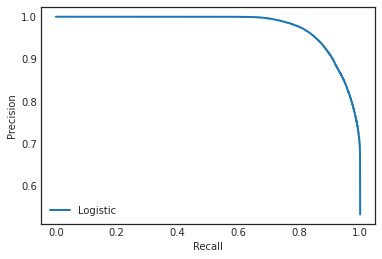

In [17]:
X_test = np.loadtxt(X_test_path, dtype=float)
y_test = np.loadtxt(y_test_path, dtype=float)

y_pred = xgb_model.predict(X_test)
lr_probs = xgb_model.predict_proba(X_test)[:,1]

lr_auc = roc_auc_score(y_test, lr_probs)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
roc_auc = roc_auc_score(y_test, lr_probs)



print(f'ACCURACY: {xgb_model.score(X_test, y_test)}')
print(f'ROC AUC SCORE: {roc_auc_score(y_test, lr_probs):.2f}')
print(classification_report(y_test, y_pred))

print(f'CONFUSION MATRIX: {confusion_matrix(y_test, y_pred)}')

#CONFUSION MATRIX PLOT
plt.style.use('seaborn-white')
plot_confusion_matrix(xgb_model, X_test, y_test)

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()


#ROC AUC CURVE
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
#ax1.set_facecolor('w')
ax1.plot(lr_fpr, lr_tpr, label="label", linewidth=2)
# axis labels
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
# show the legend

metrics_dict = {"Classification": {'precision': lr_precision, 'recall': lr_recall, 'false_positives': lr_fpr, 'true_positives': lr_tpr}}
    
#PRECISION RECALL PLOT
#ax2.set_facecolor('w')
ax2.plot(lr_recall, lr_precision, label='Logistic', linewidth=2)
# axis labels
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
# show the legend
plt.legend()

# show the plot
plt.show()

### Conclusion on model
Based on the hyperparameters selected the best XGBoost model has the below parameters and an accuracy of 90.57%. As this predition isn't a critical model
to predict eg. a disease we don't need to lower false negatives as much as possibel. In this case "accuracy" is a udeful metric to use.

In [18]:
print(xgb_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=0,
              learning_rate=0.05, max_delta_step=0, max_depth=24,
              min_child_weight=1, missing=nan, n_estimators=1800, n_jobs=1,
              nthread=None, objective='binary:logistic',
              predictor='gpu_predictor', random_state=42, reg_alpha=0.1,
              reg_lambda=1, sampling_method='gradient_based',
              scale_pos_weight=1, seed=None, silent=None, subsample=0.9,
              tree_method='gpu_hist', verbosity=1)


## Register onnx model

In [19]:
train_step = pipeline_run.find_step_run('hd_step')
train_onnx_ref = train_step[0].get_output_data("onnx_model")

def_blob_store.download(
    target_path='./output/', # str: local directory to download to
    prefix=train_onnx_ref.path_on_datastore,
    overwrite=True,
    )

onnx_path = f"./output/{train_onnx_ref.path_on_datastore}/xgboost_model.onnx"


Model.register(workspace=ws,
               model_name='XGBoost_HD_onnx',
               tags={'onnx': 'xgboost'},
               model_path=onnx_path,
               description="Health insurance cross sell car insurance")

Downloaded azureml/dacd8e87-d2e8-45ed-a814-00ff1b3641a3/onnx_model/xgboost_model.onnx, 1 files out of an estimated total of 1
Registering model XGBoost_HD_onnx


Model(workspace=Workspace.create(name='michaels_test1', subscription_id='336509a3-005c-4650-b1e5-e1c99e57a5e1', resource_group='ms_test'), name=XGBoost_HD_onnx, id=XGBoost_HD_onnx:3, version=3, tags={'onnx': 'xgboost'}, properties={})

## Show output from steps and make scaler available for score script 

In [20]:
# Get Steps 
##REF https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/machine-learning-pipelines/intro-to-pipelines/aml-pipelines-with-data-dependency-steps.ipynb
for step in pipeline_run.get_steps():
    print("Outputs of step " + step.name)
    
    # Get a dictionary of StepRunOutputs with the output name as the key 
    output_dict = step.get_outputs()
    
    for name, output in output_dict.items():
        
        output_reference = output.get_port_data_reference() # Get output port data reference
        print("\tname: " + name)
        print("\tdatastore: " + output_reference.datastore_name)
        print("\tpath on datastore: " + output_reference.path_on_datastore)

Outputs of step register_model
Outputs of step hd_step
	name: saved_model
	datastore: workspaceblobstore
	path on datastore: azureml/dacd8e87-d2e8-45ed-a814-00ff1b3641a3/saved_model
	name: onnx_model
	datastore: workspaceblobstore
	path on datastore: azureml/dacd8e87-d2e8-45ed-a814-00ff1b3641a3/onnx_model
Outputs of step prep_step
	name: X_train
	datastore: workspaceblobstore
	path on datastore: azureml/b2a059e5-70af-4dc5-a473-7b2bf0117173/X_train
	name: y_train
	datastore: workspaceblobstore
	path on datastore: azureml/b2a059e5-70af-4dc5-a473-7b2bf0117173/y_train
	name: X_test
	datastore: workspaceblobstore
	path on datastore: azureml/b2a059e5-70af-4dc5-a473-7b2bf0117173/X_test
	name: scaler_file
	datastore: workspaceblobstore
	path on datastore: azureml/b2a059e5-70af-4dc5-a473-7b2bf0117173/scaler_file
	name: y_test
	datastore: workspaceblobstore
	path on datastore: azureml/b2a059e5-70af-4dc5-a473-7b2bf0117173/y_test


## Model Deployment

In [21]:
inference_config = InferenceConfig(source_directory='./score/', entry_script="score.py", environment=myenv)

deployment_config = AciWebservice.deploy_configuration(cpu_cores = 1, memory_gb = 2, auth_enabled = True, enable_app_insights=True)

service = Model.deploy(
    workspace = ws,
    name = "health-insurance-service",
    models = [model],
    inference_config = inference_config,
    deployment_config = deployment_config,
    overwrite=True)

In [27]:
service.wait_for_deployment(show_output = True)
print(service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
SucceededACI service creation operation finished, operation "Succeeded"
Healthy


In [28]:
scoring_uri = service.scoring_uri
print(f"SCORING URI: {service.scoring_uri}")
print(f"SWAGGER URI: {service.swagger_uri}")

SCORING URI: http://b7ae4e75-d4c3-4aba-8a9d-9688a27fcb85.northeurope.azurecontainer.io/score
SWAGGER URI: http://b7ae4e75-d4c3-4aba-8a9d-9688a27fcb85.northeurope.azurecontainer.io/swagger.json


## Test webservice by posting input and get prediction

In [29]:
import requests

primary_key, secondary_key = service.get_keys()

input_data = json.dumps(X_test[1].tolist())

headers = {'Content-Type': 'application/json'}

# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {primary_key}'

# Make the request and display the response
resp = requests.post(scoring_uri, input_data, headers=headers)
print(f"PREDICTION: {json.loads(resp.text)}")

PREDICTION: [0.0]


## Get logs from webservice and clean by deleting webservice and compute_target

In [30]:
service.get_logs

<bound method Webservice.get_logs of AciWebservice(workspace=Workspace.create(name='michaels_test1', subscription_id='336509a3-005c-4650-b1e5-e1c99e57a5e1', resource_group='ms_test'), name=health-insurance-service, image_id=None, compute_type=None, state=ACI, scoring_uri=Healthy, tags=http://b7ae4e75-d4c3-4aba-8a9d-9688a27fcb85.northeurope.azurecontainer.io/score, properties={}, created_by={'hasInferenceSchema': 'False', 'hasHttps': 'False'})>

In [ ]:
service.delete
compute_target.delete()